In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [17]:
data = pd.read_csv("train.csv")
data.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


In [3]:
def train_test_split(data, proportion):
    """
    Train-validation split for the training data
    supplied by the Kaggle.
    
    """
    np.random.seed(0)
    test_indices = np.random.randint(0, len(data), int(len(data) * (1 - proportion)))
    train_indices  = [i for i in range(len(data)) if i not in test_indices]
    
    train = data.iloc[train_indices, :].reset_index(drop=True, inplace=False)
    test  = data.iloc[test_indices, :].reset_index(drop=True, inplace=False)
    
    return train, test

train, test = train_test_split(data, 0.8)
print(train.shape)

(204760, 102)


<AxesSubplot:>

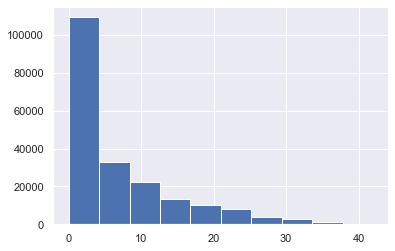

In [4]:
def oversample(train_actual, proportion):
    """
    The distribution of the outcome variable is very skewed, 
    thus oversampling to reduce the future model bias.
    
    Parameters:
    -----------
    proportion : float -- higher values result in more even distribution
    """
    
    # oversampling less represented "loss values"
    train = train_actual.copy(deep=True)
    
    # find the percentage of each "loss" value (43 percentages in total)
    unique, counts = np.unique(train_actual["loss"], return_counts=True)
    counts = np.round(5 - (counts / train_actual.shape[0]) * 150, 3)
    
    value_proportions = dict(zip(unique, [max(0, i) for i in counts]))
    # print("All value proportions:", value_proportions, "\n")
    
    threshold = train_actual.shape[0] * proportion
    
    for value, proportion in value_proportions.items():
        if proportion > 0.01:
            df = train[train["loss"] == value]
            temp = df.sample(frac=threshold / df.shape[0], replace=True, random_state=0)
            # print(f"Appending for value {value}: {temp.shape} from original distribution of {df.shape}")
            train = train.append(temp)
    
    return train

#train = oversample(train)
train["loss"].hist()

In [5]:
def separate(train, test):
    """
    Preparing the data to be fed into the model.
    """
    
    y_train = train["loss"]
    X_train = train.drop(["id", "loss"], axis=1)

    y_valid = test["loss"]
    X_valid = test.drop(["id", "loss"], axis=1)
        
    return X_train, X_valid, y_train, y_valid

X_train, X_valid, y_train, y_valid = separate(train, test)

print(f"y_train shape: {y_train.shape}, \t y_valid shape: {y_valid.shape}.")

y_train shape: (204760,), 	 y_valid shape: (49999,).


In [6]:
X_train.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
count,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,...,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000,204760.000000
mean,0.511016,51.395439,0.106108,0.050151,3586.819106,8.205530,164.532354,0.375438,16.533293,1.190472,...,0.581263,4854.709514,22.583797,2.030926,0.079826,1.538489,2.416133,0.537448,1.575863,8.043047
std,0.307947,42.393163,1.324356,0.792118,6065.174669,5.479797,183.251598,0.814008,99.680196,0.099733,...,0.444984,8505.276032,14.843252,0.900378,0.588100,9.233067,0.892662,0.226433,0.645010,5.640843
min,-0.069273,-17.000000,-7.895580,-1.475560,-7589.280000,-3.291050,-40.967200,-4.143080,-502.813000,0.934037,...,-0.379189,-12695.700000,-4.059170,0.057800,-1.998800,-24.686300,-1.131980,0.009283,-0.634764,-0.842397
25%,0.251053,18.000000,-0.612037,-0.719922,163.827000,4.107992,27.893700,-0.026269,-17.451725,1.132620,...,0.281195,73.254425,11.545275,1.471658,-0.409074,-4.001025,1.905857,0.359925,1.215580,3.732570
50%,0.514760,41.000000,0.252718,0.004480,943.637000,7.476020,91.094000,0.619717,8.639615,1.170380,...,0.480727,1055.790000,19.990800,1.660870,0.215869,0.751299,2.340000,0.531162,1.450285,7.175135
75%,0.777339,75.000000,0.759259,0.765261,4101.207500,11.025050,241.061500,0.933746,55.130550,1.219010,...,0.766370,5561.115000,32.273250,2.323313,0.503284,6.183922,2.908243,0.709532,1.899860,10.994425
max,1.072070,273.000000,9.768590,1.680190,37847.500000,35.078000,947.143000,4.010380,465.956000,1.712450,...,3.365960,54334.600000,79.912400,5.403020,1.944190,42.782000,5.576040,1.105400,4.492620,33.907600


In [7]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [21]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[X_train.shape[-1]]),
    
    layers.Dense(units=128, activation="relu"),
    layers.Dropout(0.6),
    
    layers.BatchNormalization(),
    layers.Dense(units=128, activation="relu"),
    layers.Dropout(0.6),
    
    layers.BatchNormalization(),
    layers.Dense(units=128, activation="relu"),
    layers.Dropout(0.6),
    
    layers.BatchNormalization(),
    layers.Dense(units=128, activation="relu"),
    layers.Dropout(0.6),
    
    layers.Dense(units=43, activation="relu"),
    layers.Dropout(0.6),
    
    layers.Dense(units=1)
])

model.compile(optimizer="Adam", loss="mae")

early_stopping = callbacks.EarlyStopping(patience=60,
                                         monitor="val_loss",
                                         min_delta=0.01,
                                         verbose=1,
                                        restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.7, 
    patience=4, 
    verbose=1,
    mode='min', 
    restore_best_weights=True)

training = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=128,
                    epochs=300,
                    verbose=1,
                    callbacks=[plateau, early_stopping])

model_df = pd.DataFrame(training.history)

Epoch 1/300
1600/1600 [==============================] - 7s 4ms/step - loss: 5.8909 - val_loss: 5.8211
Epoch 2/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.8012 - val_loss: 5.8301
Epoch 3/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7683 - val_loss: 5.8042
Epoch 4/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7482 - val_loss: 5.7996
Epoch 5/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7359 - val_loss: 5.7718
Epoch 6/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7232 - val_loss: 5.7554
Epoch 7/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7177 - val_loss: 5.7439
Epoch 8/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7130 - val_loss: 5.7419
Epoch 9/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.7104 - val_loss: 5.7408
Epoch 10/300
1600/1600 [==============================] - 7s 4ms/step - l

1600/1600 [==============================] - 8s 5ms/step - loss: 5.6609 - val_loss: 5.7322
Epoch 77/300
1600/1600 [==============================] - 6s 4ms/step - loss: 5.6634 - val_loss: 5.7300
Epoch 78/300
1600/1600 [==============================] - 7s 4ms/step - loss: 5.6609 - val_loss: 5.7303
Epoch 79/300
1600/1600 [==============================] - 8s 5ms/step - loss: 5.6605 - val_loss: 5.7301
Epoch 80/300
1600/1600 [==============================] - 8s 5ms/step - loss: 5.6614 - val_loss: 5.7310
Epoch 81/300
1600/1600 [==============================] - 8s 5ms/step - loss: 5.6588 - val_loss: 5.7304
Epoch 82/300
1600/1600 [==============================] - 7s 5ms/step - loss: 5.6633 - val_loss: 5.7320
Epoch 83/300
1600/1600 [==============================] - 8s 5ms/step - loss: 5.6619 - val_loss: 5.7315
Epoch 84/300
1600/1600 [==============================] - 8s 5ms/step - loss: 5.6624 - val_loss: 5.7310
Epoch 85/300
1600/1600 [==============================] - 7s 4ms/step - loss:

In [27]:
model.evaluate(X_valid, y_valid)
preds = np.round(np.squeeze(model.predict(X_valid)), 0)
random = np.random.randint(8, 9, size=len(preds))
result = np.sum(np.abs(preds - y_valid)) / len(preds)
random_result = np.sum(np.abs(random - y_valid)) / len(random)
print(result)
print(random_result)

1563/1563 [==============================] - 1s 898us/step - loss: 5.7329 0s
5.733194663893278
6.591711834236685


In [12]:
forest = RandomForestRegressor(n_estimators=500, verbose=2, n_jobs=-1)
forest.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 500
building tree 2 of 500building tree 3 of 500
building tree 4 of 500

building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.1min


building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 39.0min


building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 140.2min


building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 188.8min finished


NameError: name 'X_test' is not defined

In [13]:
preds = forest.predict(X_valid)
print(f"MAE: {mean_absolute_error(y_valid, preds)}")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   17.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   24.2s finished


MAE: 6.316291885837716


In [78]:
def calculate_loss(predictions, truth):
    return np.sum(np.abs(predictions - truth)) / len(truth)

float_preds = np.squeeze(model.predict(X_valid))
int_preds   = np.round(float_preds, 0)

print(f"Loss for float   outputs: {calculate_loss(float_preds, y_valid)}")
print(f"Loss for integer outputs: {calculate_loss(int_preds, y_valid)}")
print(np.unique(int_preds))

Loss for float   outputs: 7.183373584943398
Loss for integer outputs: 7.180127205088204
[ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 26.
 28.]


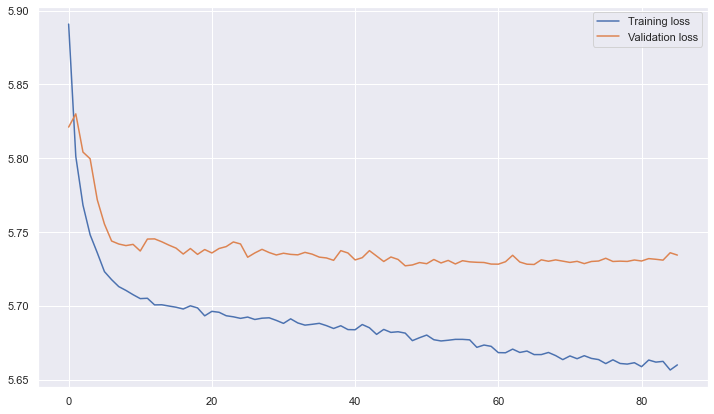

Number of epochs trained: 86
Training loss: 5.66,	 validation_loss:5.734


In [24]:
def plot_performance(data):
    loss = np.array(data["loss"])
    val_loss = np.array(data["val_loss"])
    
    plt.figure(figsize=(12, 7))
    plt.plot(loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend()
    plt.show()
    print(f"Number of epochs trained: {len(loss)}")
    print(f"Training loss: {round(loss[-1], 3)},\t validation_loss:{round(val_loss[-1], 3)}")
    return loss, val_loss

all_models.append(plot_performance(model_df))

In [14]:
submission = pd.read_csv("test.csv")
X_test = submission.drop("id", axis=1)
X_test = scaler.transform(X_test)

In [15]:
def prepare_submission(model, X_test):
    preds = np.round(np.squeeze(model.predict(X_test)), 0)
    final = pd.DataFrame()
    final["id"] = submission["id"]
    final["loss"] = preds
    final.to_csv("submission.csv", index=False)
    
prepare_submission(forest, X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   34.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   47.6s finished


In [102]:
print(X_valid.shape)
print(X_test.shape)
temp = np.array(X_test.iloc[12333]).reshape(1, -1)
model.predict(temp)

(24999, 100)
(150000, 100)


array([[578253.4]], dtype=float32)